In [141]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from IPython.display import display, HTML
import ast

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


<h2>Features</h2>

In the previous notebook, we created the variables to define the characteristic of a certain coin. In this notebook, we will take a step further in processing these variables to create the following features for training:
1. Mean
2. Median
3. Standard Deviation
4. Last Value
5. Overall trend (Difference between first and last value)

These features will be calculated for each variable we created previously and will be built based on a trailing window of width $w$ for a certain coin. $w$ is measured in days. To illustrate this, take a look at an example below.

In [2]:
# Get processed data
df = pd.read_csv("./data/processed_data.csv")

In [3]:
btc_df = df[df['sym'] == 'BTC'].iloc[-11:, :]

In [4]:
btc_df

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
95782,1.160370e+11,Bitcoin,7083.80,BTC,2018-04-02,4.333440e+09,1.0,0.458644,1800,-0.033819
95783,1.204150e+11,Bitcoin,7456.11,BTC,2018-04-03,5.499700e+09,1.0,0.458281,1801,-0.049934
95784,1.264340e+11,Bitcoin,6853.84,BTC,2018-04-04,4.936000e+09,1.0,0.451130,1802,0.087873
95785,1.161420e+11,Bitcoin,6811.47,BTC,2018-04-05,5.639320e+09,1.0,0.454319,1803,0.006220
95786,1.156010e+11,Bitcoin,6636.32,BTC,2018-04-06,3.766810e+09,1.0,0.451979,1804,0.026393
95787,1.124670e+11,Bitcoin,6911.09,BTC,2018-04-07,3.976610e+09,1.0,0.453760,1805,-0.039758
95788,1.173920e+11,Bitcoin,7023.52,BTC,2018-04-08,3.652500e+09,1.0,0.454923,1806,-0.016008
95789,1.195160e+11,Bitcoin,6770.73,BTC,2018-04-09,4.894060e+09,1.0,0.451838,1807,0.037336
95790,1.153060e+11,Bitcoin,6834.76,BTC,2018-04-10,4.272750e+09,1.0,0.446148,1808,-0.009368
95791,1.161260e+11,Bitcoin,6968.32,BTC,2018-04-11,4.641890e+09,1.0,0.441747,1809,-0.019167


The data above shows the last 11 data points in the BTC timeline. Assume that we are trying to predict for its price on 2018-04-12 (which we can annotate as $t$) and that we have decided to $w$ be 10. This means, to calculate the features to predict for this time step $t$, we will use the previous 10 data points preceding $t$. In this case, the average price will be the average of prices between 2018-04-02 ($t-10$) and 2018-04-11 ($t-1$), inclusive. 

In [5]:
mean_price = btc_df['price'][1:10].mean()
print(mean_price)

6918.462222222222


Therefore, the general equation to calculate mean for a given $w$ is as follows:

$$mean = \frac{1}{w}{\textstyle\sum}_{n=1}^{w}{V_{t-n}}$$
<div style="text-align: center">Where $V$ can be any coin related variables we defined previously such as market capitalization, volume, rank, etc. </div></br>


Similarly median, standard deviation, last value and overall trend are calculated in a similar manner in terms of the data points being used even though the equation to process them are different.

<h2>Feature Engineering</h2>

This part is meant to develop the function to calculate the features for a given $w$.

In [95]:
w = 7

In [96]:
# Function to rename the column for the features created
def rename_columns(df, suffix):
    if 'index' in df.columns:
        df.drop(columns='index', inplace=True)
    else:
        pass
    col_names = [col + '_' + suffix for col in df.columns]
    df.columns = col_names

In [97]:
def create_features(df, w):
    # Calculate mean
    mean_df = df.groupby('sym').shift(1).rolling(w).mean().reset_index()
    rename_columns(mean_df, '1_mean') # Numbers are assigned to the suffix for column ordering

    # Calculate median
    median_df = df.groupby('sym').shift(1).rolling(w).median().reset_index()
    rename_columns(median_df, '2_median')
    
    # Calculate standard deviation
    stdev_df = df.groupby('sym').shift(1).rolling(w).std().reset_index()
    rename_columns(stdev_df, '3_stdev')
    
    # Identify last value
    last_df = df.groupby('sym').shift(1)
    rename_columns(last_df, '4_last')
    
    # Identify first value and calculate difference between first and last value
    first_df = df.groupby('sym').shift(w)
    delta_df = pd.DataFrame()
    for col in first_df.columns:
        col_last = col + '_4_last'
        try:
            delta_df[col] = last_df[col_last] - first_df[col]
        except:
            pass
    rename_columns(delta_df, '5_delta')
    
    # Create base table to match created features with its respective time and coin
    base_df = df[['time', 'sym', 'price']]
    
    # Set current price as the target price to predict based on the features
    base_df = base_df.rename(columns={'price': 'target_price'})
    
    # Combine all features into a single table
    features_df = pd.concat([base_df, mean_df, median_df, stdev_df, last_df, delta_df], axis=1)
    
    # Clean up table by removing unnecessary columns and rearrange for ease of reference
    feature_cols = [col for col in features_df.columns]
    
    feature_cols.remove('name_4_last')
    feature_cols.remove('time_4_last')
    feature_cols.remove('time')
    feature_cols.remove('sym')
    feature_cols.remove('target_price')
    feature_cols.sort()

    features_df = features_df[['time', 'sym'] + feature_cols + ['target_price']]
    
    # Remove points where there are insufficient data points to calculate features
    # For example, any time step that does not have w data points before it will have NA features
    features_df.dropna(inplace=True)
    
    return features_df

In [98]:
features_df = create_features(df, w)

In [99]:
features_df.columns

Index(['time', 'sym', 'age_1_mean', 'age_2_median', 'age_3_stdev',
       'age_4_last', 'age_5_delta', 'market_cap_1_mean', 'market_cap_2_median',
       'market_cap_3_stdev', 'market_cap_4_last', 'market_cap_5_delta',
       'market_share_1_mean', 'market_share_2_median', 'market_share_3_stdev',
       'market_share_4_last', 'market_share_5_delta', 'price_1_mean',
       'price_2_median', 'price_3_stdev', 'price_4_last', 'price_5_delta',
       'rank_1_mean', 'rank_2_median', 'rank_3_stdev', 'rank_4_last',
       'rank_5_delta', 'roi_1_mean', 'roi_2_median', 'roi_3_stdev',
       'roi_4_last', 'roi_5_delta', 'volume_1_mean', 'volume_2_median',
       'volume_3_stdev', 'volume_4_last', 'volume_5_delta', 'target_price'],
      dtype='object')

<h2>Feature Evaluation</h2>

In this section, we will take a look at the relationship of the features to the target label or the target price to see if we can spot certain trends. Additionally, we will also look at the correlation between these features to avoid any highly correlated features which might overcomplicate the model.

In [100]:
def plotting(df_container, var, title):
    plt.figure(figsize=(5,4))

    for sym in df_container:
        df_container[sym][var].plot(label=sym, lw=1)
    plt.title(title, y=1.08)
    plt.legend()
    plt.show()

In [101]:
# Identify the top 10 coin based on market cap as of the latest date, April 24, 2018
latest_data = features_df[features_df['time'] == max(features_df['time'])]
latest_top_10 = latest_data.nlargest(10, 'market_cap_4_last')['sym'].values

# Filter processed data to include only the top 10 symbols
all_data_top_10 = features_df[features_df['sym'].isin(latest_top_10)]

# Create separate dataframe for each symbol
df_container = {}

for sym in latest_top_10:
    sym_df = features_df[features_df['sym'] == sym]
    sym_df['time'] = pd.to_datetime(sym_df['time'])
    sym_df.index = sym_df['time']
    df_container[sym] = sym_df

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [179]:
features_df[features_df['sym'] == 'BTC'][[x for x in features_df.columns if 'price' in x or 'roi' in x]].iloc[:20,:]

,price_1_mean,price_2_median,price_3_stdev,price_4_last,price_5_delta,roi_1_mean,roi_2_median,roi_3_stdev,roi_4_last,roi_5_delta,target_price
93989,121.457143,116.99,17.932231,112.50,-21.71,0.030528,0.039856,0.108872,-0.131111,-0.131111,115.91
93990,118.842857,115.91,17.076707,115.91,-28.63,0.026325,0.039856,0.110798,-0.029419,0.042049,112.30
93991,114.237143,112.50,12.804043,112.30,-26.70,0.041127,0.039856,0.102138,0.032146,-0.007710,111.50
93992,110.308571,112.30,6.707188,111.50,-5.49,0.036459,0.032146,0.102950,0.007175,-0.180961,113.57
93993,109.820000,112.30,6.248237,113.57,8.36,0.006978,0.007175,0.079049,-0.018227,-0.130193,112.67
93994,110.885714,112.50,5.960466,112.67,14.92,-0.007876,0.007175,0.064455,0.007988,-0.068329,117.20
93995,113.664286,112.67,2.099322,117.20,4.70,-0.024300,-0.018227,0.053068,-0.038652,0.092459,115.24
93996,114.055714,113.57,2.101497,115.24,-0.67,-0.003140,0.007175,0.026015,0.017008,0.046427,115.00
93997,113.925714,113.57,1.993018,115.00,2.70,0.001361,0.007175,0.023293,0.002087,-0.030059,117.98
93998,114.737143,115.00,2.345851,117.98,6.48,-0.006840,0.002087,0.020598,-0.025259,-0.032433,111.50


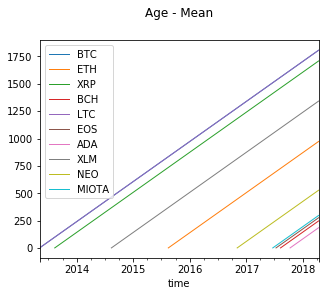

In [103]:
plotting(df_container, 'age_1_mean', 'Age - Mean')

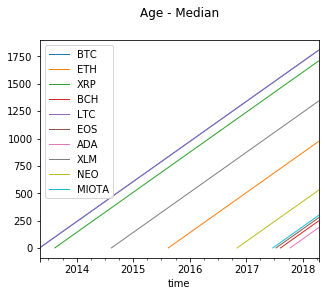

In [104]:
plotting(df_container, 'age_2_median', 'Age - Median')

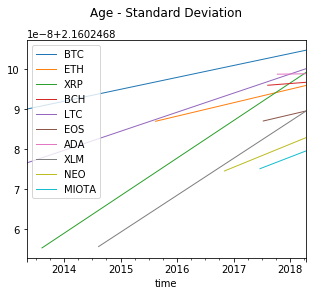

In [105]:
plotting(df_container, 'age_3_stdev', 'Age - Standard Deviation')

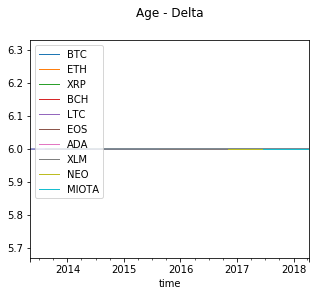

In [106]:
plotting(df_container, 'age_5_delta', 'Age - Delta')

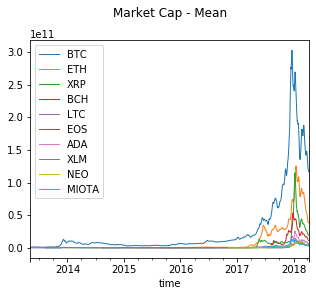

In [107]:
plotting(df_container, 'market_cap_1_mean', 'Market Cap - Mean')

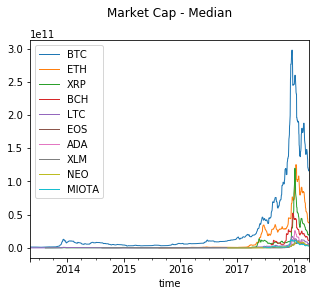

In [108]:
plotting(df_container, 'market_cap_2_median', 'Market Cap - Median')

We can see that some features related to age seem to be constant accross the given time period. They should be remove as they would not provide any predictive value to the model. Features to be removed:
1. age_1_mean
2. age_2_median
3. age_3_stdev
4. age_5_delta

We will do this by changing the `create_feature` function.

In [109]:
corr_matrix = features_df.corr().abs().round(2)
display(corr_matrix)

,age_1_mean,age_2_median,age_3_stdev,age_4_last,age_5_delta,market_cap_1_mean,market_cap_2_median,market_cap_3_stdev,market_cap_4_last,market_cap_5_delta,...,roi_2_median,roi_3_stdev,roi_4_last,roi_5_delta,volume_1_mean,volume_2_median,volume_3_stdev,volume_4_last,volume_5_delta,target_price
age_1_mean,1.00,1.00,0.01,1.00,0.01,0.07,0.07,0.05,0.07,0.00,...,0.04,0.00,0.00,0.00,0.06,0.06,0.05,0.06,0.00,0.01
age_2_median,1.00,1.00,0.01,1.00,0.01,0.07,0.07,0.05,0.07,0.00,...,0.04,0.00,0.00,0.00,0.06,0.06,0.05,0.06,0.00,0.01
age_3_stdev,0.01,0.01,1.00,0.02,0.99,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
age_4_last,1.00,1.00,0.02,1.00,0.02,0.07,0.07,0.05,0.07,0.00,...,0.04,0.00,0.00,0.00,0.06,0.06,0.05,0.06,0.00,0.01
age_5_delta,0.01,0.01,0.99,0.02,1.00,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
market_cap_1_mean,0.07,0.07,0.00,0.07,0.00,1.00,1.00,0.88,0.99,0.03,...,0.00,0.00,0.00,0.00,0.93,0.93,0.75,0.90,0.01,0.01
market_cap_2_median,0.07,0.07,0.00,0.07,0.00,1.00,1.00,0.88,0.99,0.03,...,0.00,0.00,0.00,0.00,0.93,0.93,0.75,0.90,0.01,0.01
market_cap_3_stdev,0.05,0.05,0.00,0.05,0.00,0.88,0.88,1.00,0.88,0.10,...,0.00,0.00,0.00,0.00,0.88,0.87,0.86,0.85,0.11,0.01
market_cap_4_last,0.07,0.07,0.00,0.07,0.00,0.99,0.99,0.88,1.00,0.12,...,0.00,0.00,0.00,0.00,0.93,0.92,0.76,0.90,0.04,0.01
market_cap_5_delta,0.00,0.00,0.00,0.00,0.00,0.03,0.03,0.10,0.12,1.00,...,0.02,0.00,0.00,0.00,0.03,0.02,0.14,0.09,0.33,0.00


In [157]:
def display_select_corr(corr_matrix, variable):
    selected_features = [col for col in corr_matrix.columns if variable in col]
    return corr_matrix.loc[selected_features, selected_features]

import itertools

def optimize_matrix(features_df, variable, show=True, cutoff=0.98):
    selected_features = [col for col in features_df.columns if variable in col if variable in col]
    df = features_df[selected_features]
    corr_matrix = df.corr().abs().round(2)
    lst = list(corr_matrix.columns)
    feature_combinations = []
#     selected_features = [col for col in corr_matrix.columns if variable in col if variable in col]
    for i in range(1,len(selected_features)):
        combinations = [list(x) for x in itertools.combinations(selected_features, i)]
        feature_combinations = feature_combinations + combinations
    
    selection_df = pd.DataFrame([str(comb) for comb in feature_combinations], columns=['features'])
    selection_df['feature_count'] = [len(comb) for comb in feature_combinations]
    selection_df['max_corr_count'] = selection_df['feature_count'] ** 2 - selection_df['feature_count']
    selection_df['corr_df'] = [(corr_matrix[corr_matrix.index.isin(comb)][comb] <= cutoff).values.sum() for comb in feature_combinations]

    selection_df['ratio'] = selection_df['corr_df']/selection_df['max_corr_count']
    selection_df['sum'] = [(corr_matrix[corr_matrix.index.isin(comb)][comb].values.sum()) for comb in feature_combinations]
    selection_df['exp'] = (selection_df['feature_count'] ** 2)/selection_df['sum']
#     selection_df.sort_values(by=['ratio'], ascending=False)
    if show:
        display(selection_df.nlargest(5, ['ratio', 'feature_count', 'exp']))   
    
    return ast.literal_eval(selection_df.nlargest(5, ['ratio', 'feature_count', 'exp']).iloc[0,0])

In [158]:
optimize_matrix(features_df, 'age')

,features,feature_count,max_corr_count,corr_df,ratio,sum,exp
6,"['age_1_mean', 'age_3_stdev']",2,2,2,1.0,2.02,1.980198
8,"['age_1_mean', 'age_5_delta']",2,2,2,1.0,2.02,1.980198
9,"['age_2_median', 'age_3_stdev']",2,2,2,1.0,2.02,1.980198
11,"['age_2_median', 'age_5_delta']",2,2,2,1.0,2.02,1.980198
12,"['age_3_stdev', 'age_4_last']",2,2,2,1.0,2.04,1.960784


['age_1_mean', 'age_3_stdev']

In [159]:
optimize_matrix(features_df, 'market_cap')

,features,feature_count,max_corr_count,corr_df,ratio,sum,exp
19,"['market_cap_1_mean', 'market_cap_3_stdev', 'market_cap_5_delta']",3,6,6,1.0,5.02,1.792829
22,"['market_cap_2_median', 'market_cap_3_stdev', 'market_cap_5_delta']",3,6,6,1.0,5.02,1.792829
24,"['market_cap_3_stdev', 'market_cap_4_last', 'market_cap_5_delta']",3,6,6,1.0,5.20,1.730769
8,"['market_cap_1_mean', 'market_cap_5_delta']",2,2,2,1.0,2.06,1.941748
11,"['market_cap_2_median', 'market_cap_5_delta']",2,2,2,1.0,2.06,1.941748


['market_cap_1_mean', 'market_cap_3_stdev', 'market_cap_5_delta']

In [160]:
optimize_matrix(features_df, 'price')

,features,feature_count,max_corr_count,corr_df,ratio,sum,exp
61,"['price_2_median', 'price_3_stdev', 'price_4_last', 'price_5_delta', 'target_price']",5,20,20,1.0,16.30,1.533742
60,"['price_1_mean', 'price_3_stdev', 'price_4_last', 'price_5_delta', 'target_price']",5,20,20,1.0,16.38,1.526252
53,"['price_2_median', 'price_3_stdev', 'price_5_delta', 'target_price']",4,12,12,1.0,9.42,1.698514
49,"['price_1_mean', 'price_3_stdev', 'price_5_delta', 'target_price']",4,12,12,1.0,9.48,1.687764
51,"['price_2_median', 'price_3_stdev', 'price_4_last', 'price_5_delta']",4,12,12,1.0,9.62,1.663202


['price_2_median',
 'price_3_stdev',
 'price_4_last',
 'price_5_delta',
 'target_price']

In [161]:
optimize_matrix(features_df, 'rank')

,features,feature_count,max_corr_count,corr_df,ratio,sum,exp
19,"['rank_1_mean', 'rank_3_stdev', 'rank_5_delta']",3,6,6,1.0,4.24,2.122642
22,"['rank_2_median', 'rank_3_stdev', 'rank_5_delta']",3,6,6,1.0,4.24,2.122642
24,"['rank_3_stdev', 'rank_4_last', 'rank_5_delta']",3,6,6,1.0,4.36,2.064220
13,"['rank_3_stdev', 'rank_5_delta']",2,2,2,1.0,2.12,1.886792
8,"['rank_1_mean', 'rank_5_delta']",2,2,2,1.0,2.30,1.739130


['rank_1_mean', 'rank_3_stdev', 'rank_5_delta']

In [162]:
optimize_matrix(features_df, 'roi')

,features,feature_count,max_corr_count,corr_df,ratio,sum,exp
27,"['roi_1_mean', 'roi_2_median', 'roi_4_last', 'roi_5_delta']",4,12,12,1.0,6.18,2.588997
29,"['roi_2_median', 'roi_3_stdev', 'roi_4_last', 'roi_5_delta']",4,12,12,1.0,6.18,2.588997
17,"['roi_1_mean', 'roi_2_median', 'roi_5_delta']",3,6,6,1.0,3.00,3.000000
22,"['roi_2_median', 'roi_3_stdev', 'roi_5_delta']",3,6,6,1.0,3.00,3.000000
16,"['roi_1_mean', 'roi_2_median', 'roi_4_last']",3,6,6,1.0,3.76,2.393617


['roi_1_mean', 'roi_2_median', 'roi_4_last', 'roi_5_delta']

In [163]:
optimize_matrix(features_df, 'volume')

,features,feature_count,max_corr_count,corr_df,ratio,sum,exp
29,"['volume_2_median', 'volume_3_stdev', 'volume_4_last', 'volume_5_delta']",4,12,12,1.0,9.90,1.616162
28,"['volume_1_mean', 'volume_3_stdev', 'volume_4_last', 'volume_5_delta']",4,12,12,1.0,10.00,1.600000
22,"['volume_2_median', 'volume_3_stdev', 'volume_5_delta']",3,6,6,1.0,4.86,1.851852
19,"['volume_1_mean', 'volume_3_stdev', 'volume_5_delta']",3,6,6,1.0,4.94,1.821862
23,"['volume_2_median', 'volume_4_last', 'volume_5_delta']",3,6,6,1.0,5.36,1.679104


['volume_2_median', 'volume_3_stdev', 'volume_4_last', 'volume_5_delta']

The correlation matrices show a high correlation between several features e.g. between mean and median, however it is difficult to predict whether this will be case for all values of $w$.

In [78]:
w_alt = 100
features_df_alt = create_features(df, w_alt)

In [79]:
corr_matrix_alt = features_df_alt.corr().abs().round(2)
display_select_corr(corr_matrix_alt, 'price')

,price_1_mean,price_2_median,price_3_stdev,price_4_last,price_5_delta,target_price
price_1_mean,1.00,0.98,0.85,0.85,0.45,0.85
price_2_median,0.98,1.00,0.74,0.81,0.42,0.81
price_3_stdev,0.85,0.74,1.00,0.76,0.42,0.76
price_4_last,0.85,0.81,0.76,1.00,0.75,0.97
price_5_delta,0.45,0.42,0.42,0.75,1.00,0.72
target_price,0.85,0.81,0.76,0.97,0.72,1.00


In [80]:
display_select_corr(corr_matrix, 'price')

,price_1_mean,price_2_median,price_3_stdev,price_4_last,price_5_delta,target_price
price_1_mean,1.00,0.99,0.79,0.93,0.00,0.91
price_2_median,0.99,1.00,0.73,0.92,0.01,0.91
price_3_stdev,0.79,0.73,1.00,0.76,0.09,0.72
price_4_last,0.93,0.92,0.76,1.00,0.31,0.96
price_5_delta,0.00,0.01,0.09,0.31,1.00,0.25
target_price,0.91,0.91,0.72,0.96,0.25,1.00


From the two correlation matrices above, we can see that $w$ affects the correlation profile which does not necessarily decreases the correlation values between features. As such, I suspect that training with a larger $w$ does not necessarily result in a better model. Therefore, I will not be removing anymore features. The finalize `create_feature` function will be as follows.

In [176]:
def create_features(df, w, target='price'):
    # Calculate mean
    mean_df = df.groupby('sym').shift(1).rolling(w).mean().reset_index()
    rename_columns(mean_df, '1_mean') # Numbers are assigned to the suffix for column ordering

    # Calculate median
    median_df = df.groupby('sym').shift(1).rolling(w).median().reset_index()
    rename_columns(median_df, '2_median')
    
    # Calculate standard deviation
    stdev_df = df.groupby('sym').shift(1).rolling(w).std().reset_index()
    rename_columns(stdev_df, '3_stdev')
    
    # Identify last value
    last_df = df.groupby('sym').shift(1)
    rename_columns(last_df, '4_last')
    
    # Identify first value and calculate difference between first and last value
    first_df = df.groupby('sym').shift(w)
    delta_df = pd.DataFrame()
    for col in first_df.columns:
        col_last = col + '_4_last'
        try:
            delta_df[col] = last_df[col_last] - first_df[col]
        except:
            pass
    rename_columns(delta_df, '5_delta')
    
    # Create base table to match created features with its respective time and coin
    base_df = df[['time', 'sym', target]]
    
    # Set current price as the target price to predict based on the features
    base_df = base_df.rename(columns={target: 'target'})
    
    # Combine all features into a single table
    features_df = pd.concat([base_df, mean_df, median_df, stdev_df, last_df, delta_df], axis=1)
    
    
    feature_cols = []
    for prop in ['age', 'volume', 'roi', 'price', 'rank', 'market_cap']:
        selected_cols = optimize_matrix(features_df, prop, show=False)
        feature_cols = feature_cols + selected_cols
        
    # Clean up table by removing unnecessary columns and rearrange for ease of reference
#     feature_cols = [col for col in features_df.columns]
    
#     feature_cols.remove('age_1_mean')
#     feature_cols.remove('age_2_median')
#     feature_cols.remove('age_3_stdev')
#     feature_cols.remove('age_5_delta')
#     feature_cols.remove('name_4_last')
#     feature_cols.remove('time_4_last')
#     feature_cols.remove('time')
#     feature_cols.remove('sym')
#     feature_cols.remove('target_price')
#     feature_cols.sort()
    print(feature_cols)
    features_df = features_df[['time', 'sym'] + feature_cols + ['target']]
    
    # Remove points where there are insufficient data points to calculate features
    # For example, any time step that does not have w data points before it will have NA features
    features_df.dropna(inplace=True)
    
    return features_df

In [177]:
create_features(df, 10)

['age_1_mean', 'age_3_stdev', 'age_5_delta']
['volume_2_median', 'volume_3_stdev', 'volume_4_last', 'volume_5_delta']
['roi_1_mean', 'roi_2_median', 'roi_4_last', 'roi_5_delta']
['price_2_median', 'price_3_stdev', 'price_4_last', 'price_5_delta']
['rank_1_mean', 'rank_3_stdev', 'rank_5_delta']
['market_cap_1_mean', 'market_cap_3_stdev', 'market_cap_5_delta']
['age_1_mean', 'age_3_stdev', 'age_5_delta', 'volume_2_median', 'volume_3_stdev', 'volume_4_last', 'volume_5_delta', 'roi_1_mean', 'roi_2_median', 'roi_4_last', 'roi_5_delta', 'price_2_median', 'price_3_stdev', 'price_4_last', 'price_5_delta', 'rank_1_mean', 'rank_3_stdev', 'rank_5_delta', 'market_cap_1_mean', 'market_cap_3_stdev', 'market_cap_5_delta']


,time,sym,age_1_mean,age_3_stdev,age_5_delta,volume_2_median,volume_3_stdev,volume_4_last,volume_5_delta,roi_1_mean,...,price_3_stdev,price_4_last,price_5_delta,rank_1_mean,rank_3_stdev,rank_5_delta,market_cap_1_mean,market_cap_3_stdev,market_cap_5_delta,target
10,2015-12-21,$$$,4.5,3.02765,9.0,2.0,1.646545,3.0,2.0,0.058443,...,6.454112e-06,0.000022,-0.000005,291.6,5.581716,13.0,1282.1,462.989909,-1226.0,0.000022
11,2015-12-22,$$$,5.5,3.02765,9.0,2.0,1.646545,1.0,1.0,0.058443,...,6.484169e-06,0.000022,-0.000021,293.0,4.216370,1.0,1155.0,303.439176,-229.0,0.000022
12,2015-12-23,$$$,6.5,3.02765,9.0,2.0,1.509231,1.0,-1.0,0.095652,...,5.270463e-07,0.000022,0.000000,292.9,4.201851,11.0,1130.9,305.062999,-992.0,0.000027
13,2015-12-24,$$$,7.5,3.02765,9.0,2.5,1.505545,3.0,0.0,-0.018321,...,1.490712e-06,0.000027,0.000005,294.3,1.828782,5.0,1031.5,27.857774,8.0,0.000023
14,2015-12-25,$$$,8.5,3.02765,9.0,2.0,1.509231,2.0,0.0,-0.000930,...,1.449138e-06,0.000023,0.000000,294.6,1.429841,-2.0,1053.9,62.665691,200.0,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672495,2018-04-08,ZZC,115.5,3.02765,9.0,254.5,449.959613,2.0,-249.0,0.078414,...,3.552180e-02,0.187144,-0.091161,1022.7,18.927053,9.0,158540.0,21947.729912,-34191.0,0.280132
672496,2018-04-09,ZZC,116.5,3.02765,9.0,272.0,464.033306,718.0,-683.0,0.028679,...,3.570552e-02,0.280132,0.012840,1029.4,23.632370,68.0,150422.9,23241.021198,-53344.0,0.150297
672497,2018-04-10,ZZC,117.5,3.02765,9.0,227.5,296.913714,197.0,-104.0,0.110945,...,4.602296e-02,0.150297,-0.119973,1030.1,22.922333,-4.0,150598.5,23361.325006,7829.0,0.217971
672498,2018-04-11,ZZC,118.5,3.02765,9.0,157.0,300.016700,117.0,-169.0,0.080999,...,4.456587e-02,0.217971,-0.020623,1037.4,28.802778,65.0,143691.8,30171.130379,-70797.0,0.218985
